In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
%matplotlib inline


/Users/jpeg/code/collimator-ai/lane-keeping-demo/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from single_test import load_model, infer
model, device = load_model()

Loaded pretrained weights for efficientnet-b0


In [11]:
# from PIL import Image

# pil = Image.open('image3.jpg')
# img = np.asarray(pil)

# print(pilImg)
img_bgr = cv2.imread('image1.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img_rgb, (640, 360), interpolation=cv2.INTER_LINEAR)
# img = cv2.resize(img_bgr, (640, 360), interpolation=cv2.INTER_LINEAR)
# img = img_bgr
# img = np.array(img / 255., dtype=np.float)
# print(img)

h, w = img.shape[:2]
print("img size", w, h)

transform = transforms.ToTensor()
tensor = transform(img)
tensor = tensor.unsqueeze(0)
results = infer(model, tensor, device)
results

img size 640 360


(tensor([[[ 1.0000e+00,  3.6861e-01,  6.2601e-01,  8.8186e-01, -1.0496e+00,
           -1.3048e+00,  1.0311e+00],
          [ 1.0000e+00,  3.5041e-04,  9.9182e-01,  1.2611e-01, -2.3288e-01,
           -5.0702e-01,  6.9290e-01],
          [ 9.9996e-01,  3.8367e-02,  9.6711e-01, -1.3817e-01,  3.1173e-01,
            3.3648e-01,  3.9052e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]),
 None)

lane: [ 1.          0.36860597  0.62600917  0.8818555  -1.0495651  -1.3047551
  1.0310965 ]
gt point (0.8818555, -1.3047551)
lane: [ 1.0000000e+00  3.5041105e-04  9.9182200e-01  1.2611298e-01
 -2.3288202e-01 -5.0701970e-01  6.9289762e-01]
gt point (0.12611298, -0.5070197)
lane: [ 0.99996173  0.03836678  0.96710706 -0.1381706   0.31172717  0.33648184
  0.39052272]
gt point (0.31172717, 0.39052272)
lane: [0. 0. 0. 0. 0. 0. 0.]
lane: [0. 0. 0. 0. 0. 0. 0.]


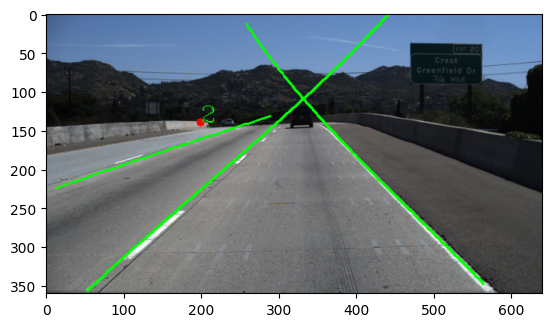

In [12]:
# poly = results[0][0][0][3:]
# x = np.linspace(0, 1, 101)
# y = np.array([np.polyval(poly, i) for i in x])
# plt.plot(x,y)

label = results[0][0]
for i, raw_lane in enumerate(label):
    raw_lane = raw_lane.cpu().numpy()
    print("lane:", raw_lane)
    if raw_lane[0] == 0:  # Skip invalid lanes
        continue

    lane = raw_lane[3:]  # remove conf, upper and lower positions
    xs = lane[:len(lane) // 2]
    ys = lane[len(lane) // 2:]
    ys = ys[xs >= 0]
    xs = xs[xs >= 0]

    # p1 = [0, int(360*raw_lane[1])]
    # p2 = [640, int(360*raw_lane[1])]
    # img = cv2.line(img, p1, p2, color=(0, 255, 255), thickness=2)

    # p1 = [0, int(360*raw_lane[2])]
    # p2 = [640, int(360*raw_lane[2])]
    # img = cv2.line(img, p1, p2, color=(0, 255, 0), thickness=2)

    # draw GT points
    for p in zip(xs, ys):
        print("gt point", p)
        p = (int(p[0] * w), int(p[1] * h))
        img = cv2.circle(img, p, 5, color=(255, 0, 0), thickness=-1)

    # draw GT lane ID
    cv2.putText(img,
                str(i), (int(xs[0] * w), int(ys[0] * h)),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=1,
                color=(0, 255, 0))

    # generate points from the polynomial
    lane = raw_lane[1:]  # remove conf
    lower, upper = lane[0], lane[1]
    lane = lane[2:]  # remove upper, lower positions
    ys = np.linspace(lower, upper, num=100)
    points = np.zeros((len(ys), 2), dtype=np.int32)
    points[:, 1] = (ys * h).astype(int)
    points[:, 0] = (np.polyval(lane, ys) * w).astype(int)
    points = points[(points[:, 0] > 0) & (points[:, 0] < w)]

    # draw lane with a polyline on the overlay
    for current_point, next_point in zip(points[:-1], points[1:]):
        img = cv2.line(img, tuple(current_point), tuple(next_point), color=(0, 255, 0), thickness=2)

plt.imshow(img)
# cv2.imshow('image',img)
# cv2.waitKey(0)